In [23]:
import psycopg2
import psycopg2.extras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
pip install Faker

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.7 MB 491.5 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.7 MB 581.0 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.7 MB 514.3 kB/s eta 0:00:04
   ---- ----------------------------------- 0.2/1.7 MB 787.7 kB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.7 MB 692.4 kB/s eta 0:00:03
   ----- ---------------------------------- 0.3/1.7 MB 684.6 kB/s eta 0:00:03
   ------- -------------------------------- 0.3/1.7 MB 731.4 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.7 MB 731.4 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.7 MB 614.4 kB/s eta 0:00:03
   -------- ------------------------------- 0.4/1.7 MB 674.7 kB/s eta 0:00:03
   --------- 

In [16]:
#creating a class so we can use objects
class PostgresConnection(object):
    #right after calling this class __init__() function will execute first
    def __init__(self):
        self.connection = psycopg2.connect(database = "mobile telecomunication",
                                           user = "postgres",
                                           password = "admin",
                                           host = "127.0.0.1",
                                           port = "5432")
        print("\nConnected!")
    #getConnection() function will call __init__() and connect
    def getConnection(self):
            print("Connection to DB established")
            return self.connection

In [17]:
#con object to initiate the connection
conn = PostgresConnection().getConnection()


Connected!
Connection to DB established


In [14]:
import psycopg2
from faker import Faker
import random
from datetime import datetime, timedelta

fake = Faker()

cursor = conn.cursor()

# Get a list of all mobile numbers from Users table
cursor.execute("SELECT MobileNumber FROM Users")
mobile_numbers = [result[0] for result in cursor.fetchall()]


# Generate and insert call data
start_date = datetime(2018, 1, 1)
end_date = datetime(2022, 12, 31)

for mobile_number in mobile_numbers:
    current_date = start_date

    while current_date <= end_date:
        for _ in range(20):  # 20 calls per user per day
            receiver_number = random.choice(mobile_numbers)
            call_datetime = current_date + timedelta(seconds=random.randint(0, 86399))  # Random time of the day
            day_of_week = call_datetime.strftime("%A")
            week_of_month = (call_datetime.day - 1) // 7 + 1
            quarter_of_month = (call_datetime.month - 1) // 3 + 1
            month = call_datetime.month
            year = call_datetime.year
            quarter_of_year = f"Q{((call_datetime.month - 1) // 3) + 1}"
            duration = random.randint(30, 600)  # Random duration between 30 seconds and 10 minutes
            cost = round(random.uniform(0.1, 10.0), 2)  # Random cost between 0.1 and 10.0

            # Get OperatorID based on the operator's name
            operator_name = random.choice(["Grameenphone", "Robi", "Banglalink"])
            cursor.execute("SELECT OperatorID FROM Operators WHERE OperatorName = %s", (operator_name,))
            operator_id = cursor.fetchone()[0]

            sql = """INSERT INTO CallDetails (CallerMobileNumber, ReceiverMobileNumber, CallDateTime, 
                     DayOfWeek, WeekOfMonth, QuarterOfMonth, Month, Year, QuarterOfYear, Duration, Cost, OperatorID) 
                     VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"""

            values = (mobile_number, receiver_number, call_datetime, day_of_week, week_of_month, 
                      quarter_of_month, month, year, quarter_of_year, duration, cost, operator_id)

            cursor.execute(sql, values)

        current_date += timedelta(days=1)

# Commit the changes
conn.commit()

# Close the connection
conn.close()

In [20]:
2011790 %6 +1

3

# 3.	operator and time dimensional call pattern analytics

## Average Duration of Calls by Operator and Month and Year

In [34]:
con = PostgresConnection().getConnection()
cur = con.cursor()
select_stmt = """  
SELECT c.operatorname, u.year,u.month, AVG(u.duration)
FROM public.calldetails u
JOIN public.operators c on c.operatorid = u.operatorid
GROUP BY CUBE(c.operatorname,u.month,u.year, u.duration)
order by u.duration DESC

"""
cur.execute(select_stmt)
records = cur.fetchall()
df = pd.DataFrame(records, columns = ['Operator_Name','Year', 'Month', 'AVG Duration'])
df=df.dropna()
df


Connected!
Connection to DB established


,Operator_Name,Year,Month,AVG Duration
1,Robi,2018.0,12.0,315.5869140625000000
3,Robi,2019.0,1.0,318.8830097087378641
4,Robi,2019.0,2.0,312.9634211941904250
5,Robi,2019.0,3.0,315.2632575757575758
6,Robi,2019.0,4.0,315.2498760535448686
...,...,...,...,...
180792,Grameenphone,2019.0,2.0,30.0000000000000000
180793,Grameenphone,2018.0,2.0,30.0000000000000000
180794,Banglalink,2022.0,2.0,30.0000000000000000
180795,Banglalink,2021.0,2.0,30.0000000000000000


Text(0, 0.5, 'Average Duration')

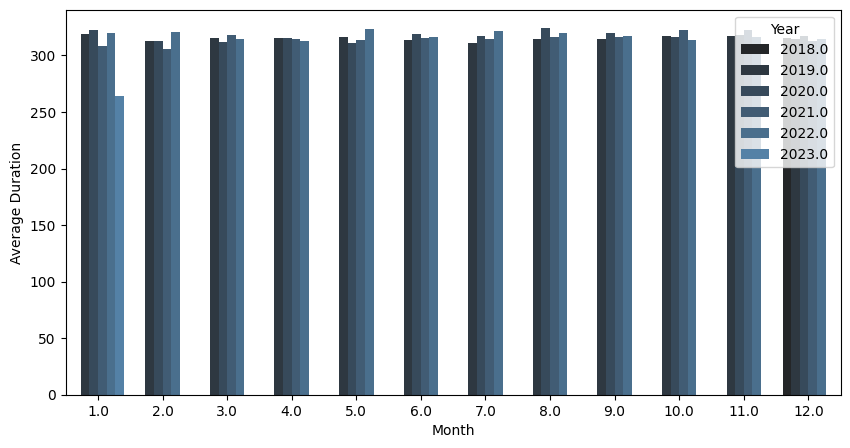

In [40]:
df = df[0:50]
plt.figure(figsize=[10,5])
sns.barplot(x=df['Month'], y= df['AVG Duration'], hue = df['Year'], legend =True, palette='dark:steelblue')
plt.xlabel("Month")
plt.ylabel("Average Duration")

# Average Cost of Calls by Operator and year

In [50]:
con = PostgresConnection().getConnection()
cur = con.cursor()
select_stmt = """  
SELECT c.operatorname,u.year, u.month, AVG(u.cost)
FROM public.calldetails u
JOIN public.operators c on c.operatorid = u.operatorid
WHERE u.Year = '2019'
GROUP BY CUBE(c.operatorname,u.year, u.month, u.duration)
order by AVG(u.cost) DESC

"""
cur.execute(select_stmt)
records = cur.fetchall()
df = pd.DataFrame(records, columns = ['Operator_Name','Years', 'Months', 'AVG COST'])
df=df.dropna()
df


Connected!
Connection to DB established


,Operator_Name,Years,Months,AVG COST
2,Banglalink,2019.0,5.0,10.0000000000000000
3,Robi,2019.0,6.0,10.0000000000000000
4,Robi,2019.0,4.0,9.9700000000000000
6,Grameenphone,2019.0,7.0,9.9700000000000000
10,Grameenphone,2019.0,1.0,9.9600000000000000
...,...,...,...,...
58266,Robi,2019.0,6.0,0.13000000000000000000
58267,Grameenphone,2019.0,7.0,0.13000000000000000000
58269,Banglalink,2019.0,3.0,0.12000000000000000000
58271,Grameenphone,2019.0,11.0,0.11000000000000000000


Text(0, 0.5, 'Average Cost')

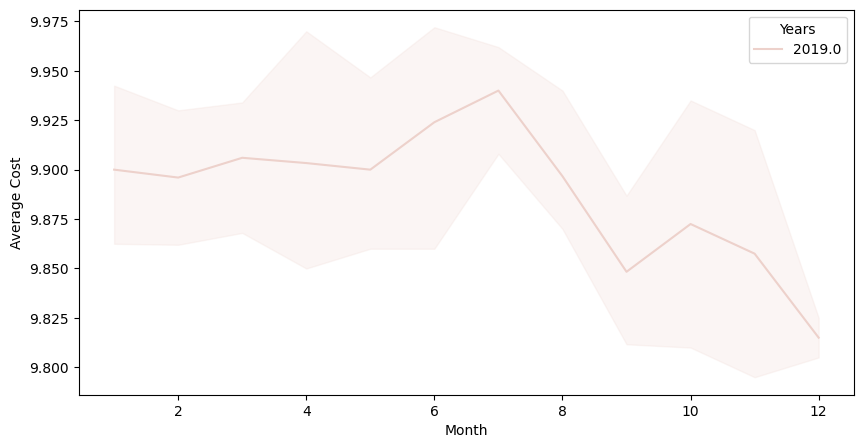

In [52]:
df = df[0:50]
plt.figure(figsize=[10,5])
sns.lineplot(x=df['Months'], y= df['AVG COST'], hue = df['Years'], legend =True)
plt.xlabel("Month")
plt.ylabel("Average Cost")